# Rewards from Linguistic Feedback
## Experiment Data Exploration

A notebook exploring the data collected during the human-human and human-agent teaching experiments.

This loads the dataset and performs some exploratory analyses visualizations.

In [40]:
# Set notebook up to load files from Science repo
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# Ensure that we re-load changes automagically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns

### Human-Human results

Loads the `human_trial_data.json` file into a dataframe, filtering for fields used in this paper.

#### Dataframe Fields

`task_uuid`: A unique key for this dyad.  
`level_number`: Integer from 1-10, indicates which round of the game. All players played levels in the same sequence.  
`chat_text`: The text sent by the teacher after the level ended. `|` is a delimiter that indicates separate chat messages.  
`game`: A dictionary containing a full record of the game, including the player's actual trajectory through space, objects collected, etc. Most `science` library functions take this as an input.  

`player_score`: The player's raw score on the level, a function of the objects collected.  
`pct_max_score`: Because possible scores based on the objects, the `pct_max_score` indicates their performance as a percent of the optimal choice.  
`cum_player_score`: The dyad's cumulative score at the end of this level.  
`cum_max_score`: The cumulative maximum score attainable by the end of this level.  

`value_mask_config`: The reward function used to encode value for this player. `shape_config` and `color_config` provide shapes and colors in increasing order; i.e. `o_^_s` indicates circle-triangle-square increasing in magnitude; `y_c_m` indicates yellow is negative, cyan zero, magenta positive.  

In [17]:
human_df = pd.read_json('data/human_trial_data.json')

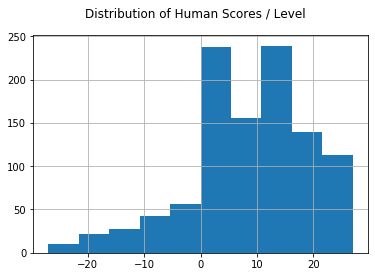

In [35]:
human_df.player_score.hist()
plt.suptitle("Distribution of Human Scores / Level");

## Player Scores over Trial

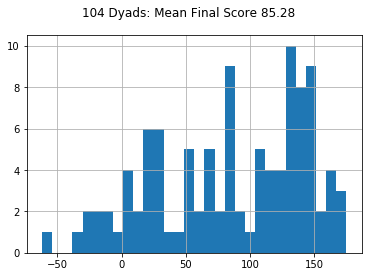

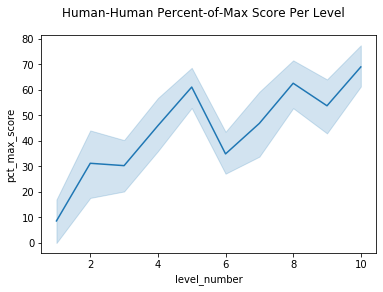

In [37]:
final_scores = human_df[human_df.level_number == 10].cum_player_score
final_scores.hist(bins=30)
plt.suptitle("{} Dyads: Mean Final Score {:.2f}".format(human_df.task_uuid.nunique(), final_scores.mean()));

plt.figure()
sns.lineplot(data=human_df, x='level_number', y='pct_max_score')
plt.suptitle("Human-Human Percent-of-Max Score Per Level");

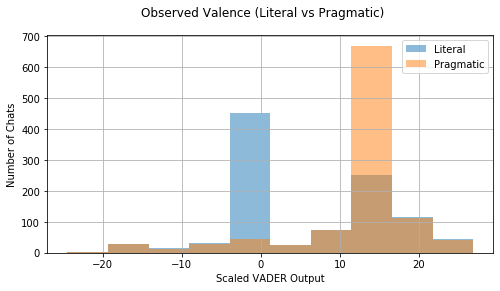

In [38]:
from science.observations.text_analysis import vader_observation, modified_vader_observation

plt.figure(figsize=(8, 4))
human_df['literal_valence'] = human_df.chat_text.apply(vader_observation) * 30
human_df['literal_valence'].hist(alpha=.5, label="Literal")

human_df['pragmatic_valence'] = human_df.chat_text.apply(modified_vader_observation)* 30

human_df['pragmatic_valence'].hist(alpha=.5, label="Pragmatic")
plt.suptitle("Observed Valence (Literal vs Pragmatic)")
plt.legend(loc='best')
plt.xlabel("Scaled VADER Output")
plt.ylabel("Number of Chats");

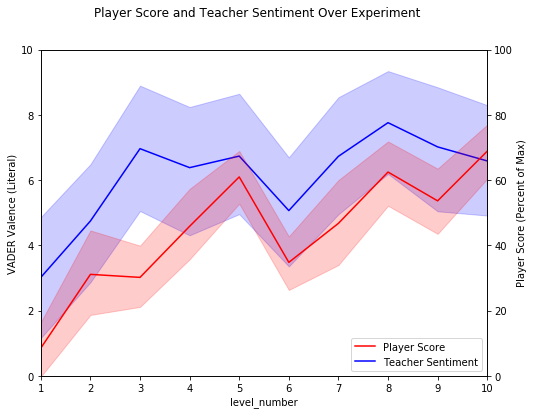

In [39]:
import seaborn as sns

plt.figure(figsize=(8, 6))

ax = sns.lineplot(data=human_df, x='level_number', y='literal_valence', color='blue')
new_ax = ax.twinx()
sns.lineplot(ax=new_ax, data=human_df, x='level_number', y='pct_max_score', color='red', label="Player Score")
new_ax.plot([], c='blue', label="Teacher Sentiment")
new_ax.legend(loc=4)

plt.xlabel("Level Number")
ax.set_ylabel("VADER Valence (Literal)")
ax.set_ylim(0, 10)
new_ax.set_ylabel("Player Score (Percent of Max)")
new_ax.set_ylim(0, 100)
ax.set_xlim(1, 10)

plt.suptitle("Player Score and Teacher Sentiment Over Experiment");

## Visualize a single level

Visualize the player's trajectory and teacher's feedback.

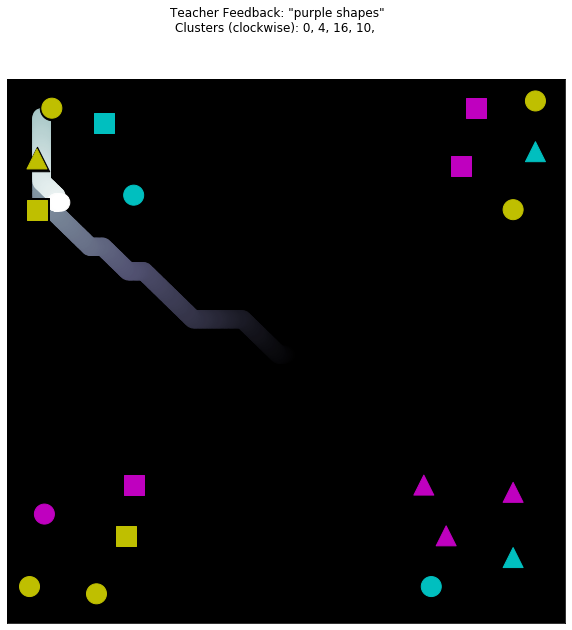

In [22]:
from science.analysis.visualization import overlay_traces

example_record = human_df[(human_df.task_uuid == 'A2YNHC0B210HLK:3BGYGHDBBZ8MFT5NW5HGTCKKWN122H') & (human_df.level_number == 2)]

example_chat = example_record.chat_text.iloc[0]
example_value_mask = example_record.value_mask_config.iloc[0]

overlay_traces(example_record.game, alpha=1, title='Teacher Feedback: \"{}\"'.format(example_chat),
               first_trajectory_color='bone', value_mask_config=example_value_mask)

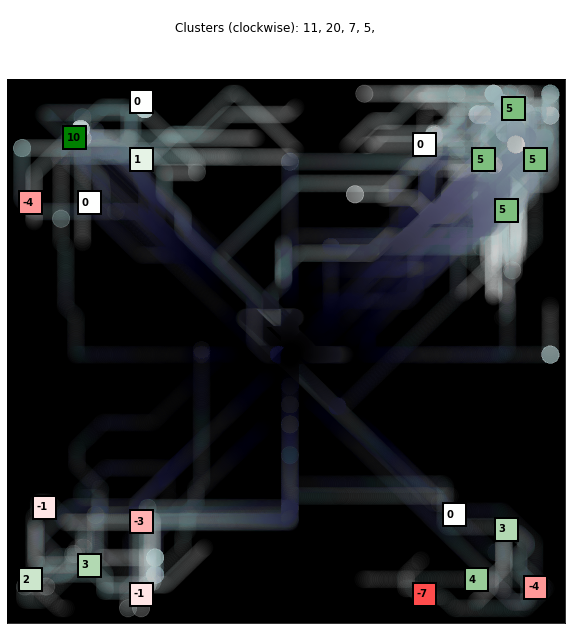

In [23]:
overlay_traces(human_df[human_df.level_number == 10].game, first_trajectory_color='bone', alpha=.02)

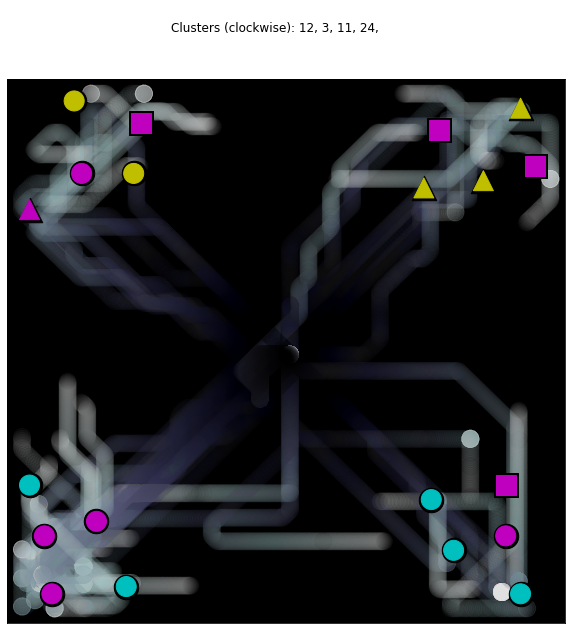

In [24]:
overlay_traces(human_df[human_df.level_number == 4].sample(50).game, first_trajectory_color='bone', alpha=.03, value_mask_config=example_value_mask)

## Chat Text

In [25]:
random_teachers = human_df.task_uuid.sample(n=3)
random_dyads = human_df[human_df.task_uuid.isin(random_teachers)]

for dyad_uuid, g in random_dyads.groupby("task_uuid"):
    
    final_score = g[g.level_number==10].iloc[0]["cum_player_score"]
    print("{}: {}".format(dyad_uuid, final_score))
    for k, row in g.sort_values("level_number", ascending=True).iterrows():
        print("{}\t{}".format(int(row["pct_max_score"]), row["chat_text"]))

A18VIO909RWY6D:39N5ACM9HGBT7KRSJC77ZC0RD2H9PF: 150
31	blue was positive this time so you got it. But I'm not sure how to predict how it will change since I can only send a message after the round ends|
100	Just keep going for those three blue in the bottom right corner, they're the highest scoring group of points if the game doesn't change|
35	good job. seems like blue is always positive points|
100	I don't know what else to say lol you got this just keep going for blue|
100	okay so in order of value from most to least it goes triangle, square, circle. So blue triangle is worth the most points|
100	sweet|
50	yellow is negative points so avoid those|
100	teamwork makes the dream work|
74	hip hip|
100	hooray|
A1IA0LI13Y1RLE:3VW6495TLLO2HZR1IBV6BKMUQHQYYA: 80
43	you are doing fine
-87	light blue shapes are positive number, and pink is negative number
17	yellow shapes are 0 point
100	good job
80	light blue triangles are worth high point (0-10), light blue rectangles are low point (1-2), an

### Explore Reference Types

Uses phrase-type classifier to analyze corpus

In [26]:
from science.observations.text_analysis import classify_phrase_reference_type, limited_punc_tokenization, vader_observation

def contains_phrase_type(chat, phrase_type):
    
    if chat is None:
        return False
    phrases = limited_punc_tokenization(chat)
    classifications = [classify_phrase_reference_type(p) for p in phrases]
    return any(c == phrase_type for c in classifications)

human_df["feature"] = human_df.chat_text.apply(lambda x: contains_phrase_type(x, "feature"))
human_df["trajectory"] = human_df.chat_text.apply(lambda x: contains_phrase_type(x, "trajectory"))
human_df["action"] = human_df.chat_text.apply(lambda x: contains_phrase_type(x, "action_spatial"))

In [27]:
print("{} total chats.".format(len(human_df)))
for phrase_type in ["feature", 'trajectory', 'action']:
    print("\t{}: {} of chats ({:.2f}%%)".format(phrase_type, len(human_df[human_df[phrase_type]]), human_df[phrase_type].mean()*100))

1040 total chats.
	feature: 347 of chats (33.37%%)
	trajectory: 677 of chats (65.10%%)
	action: 62 of chats (5.96%%)


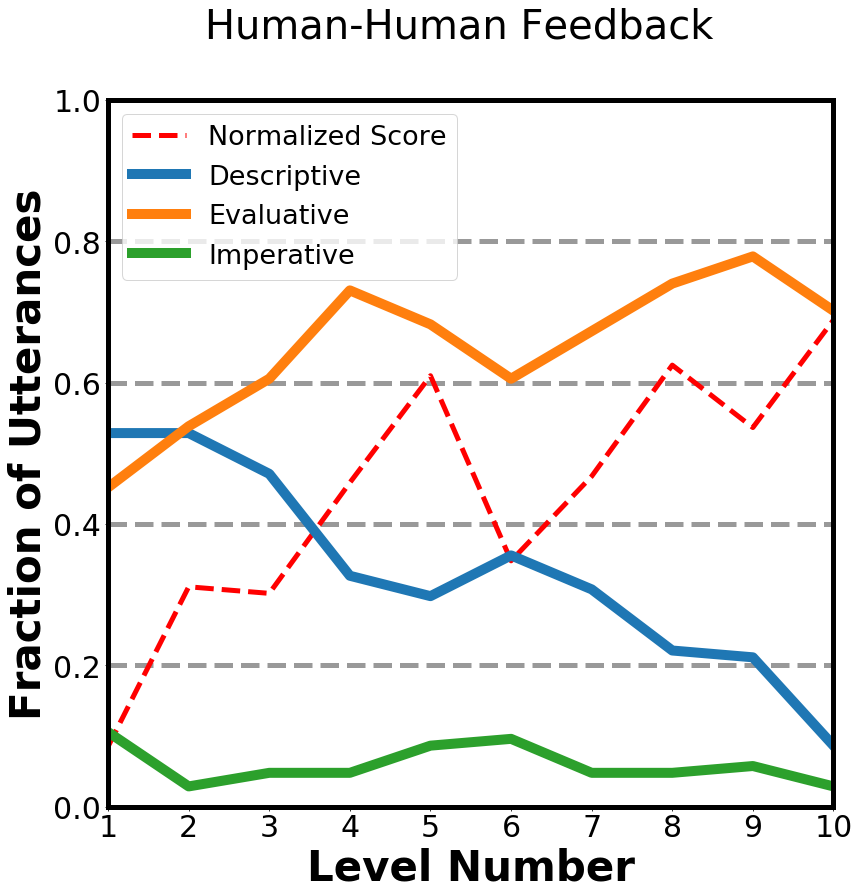

In [28]:
plt.figure(figsize=(13,13), linewidth=30)

for x in [.2, .4, .6, .8]:
    plt.axhline(x, linestyle='--', c='k', alpha=.4, linewidth=5)

human_df["frac_max_score"] = human_df.pct_max_score/100
human_df.groupby("level_number").frac_max_score.mean().plot(label="Normalized Score", linewidth=5,linestyle='--', color='r')

human_df.groupby("level_number").feature.mean().plot(label="Descriptive", linewidth=10)
human_df.groupby("level_number").trajectory.mean().plot(label="Evaluative", linewidth=10)
human_df.groupby("level_number").action.mean().plot(label="Imperative", linewidth=10)

plt.ylim(0,1)
plt.xlim(1, 10)
plt.legend(loc=2, prop={'size': 27})
plt.ylabel("Fraction of Utterances", fontsize=42, weight="bold")
plt.xlabel("Level Number", fontsize=42, weight="bold")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax = plt.gca()
ax.spines["top"].set_linewidth(5)
ax.spines["bottom"].set_linewidth(5)
ax.spines["left"].set_linewidth(5)
ax.spines["right"].set_linewidth(5)

plt.suptitle("Human-Human Feedback", fontsize=40);


# Human-Agent Results

In [29]:
agent_df = pd.read_json("data/agent_trial_data.json")

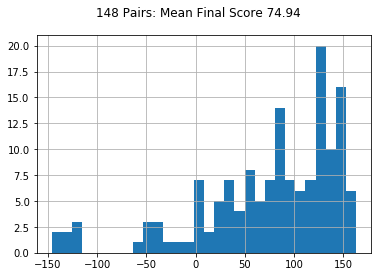

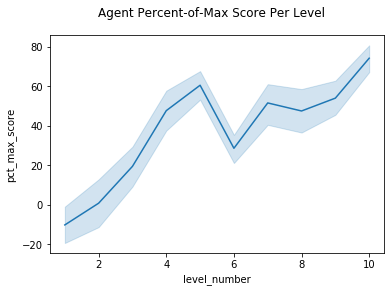

In [31]:
final_scores = agent_df[agent_df.level_number == 10].cum_player_score
final_scores.hist(bins=30)
plt.suptitle("{} Pairs: Mean Final Score {:.2f}".format(agent_df.task_uuid.nunique(), final_scores.mean()));

plt.figure()
sns.lineplot(data=agent_df, x='level_number', y='pct_max_score')
plt.suptitle("Agent Percent-of-Max Score Per Level");

In [32]:
agent_df["feature"] = agent_df.chat_text.apply(lambda x: contains_phrase_type(x, "feature"))
agent_df["trajectory"] = agent_df.chat_text.apply(lambda x: contains_phrase_type(x, "trajectory"))
agent_df["action"] = agent_df.chat_text.apply(lambda x: contains_phrase_type(x, "action_spatial"))

print("{} total chats.".format(len(agent_df)))
for phrase_type in ["feature", 'trajectory', 'action']:
    print("\t{}: {} of chats ({:.2f}%%)".format(phrase_type, len(agent_df[agent_df[phrase_type]]), agent_df[phrase_type].mean()*100))

1480 total chats.
	feature: 738 of chats (49.86%%)
	trajectory: 722 of chats (48.78%%)
	action: 87 of chats (5.88%%)


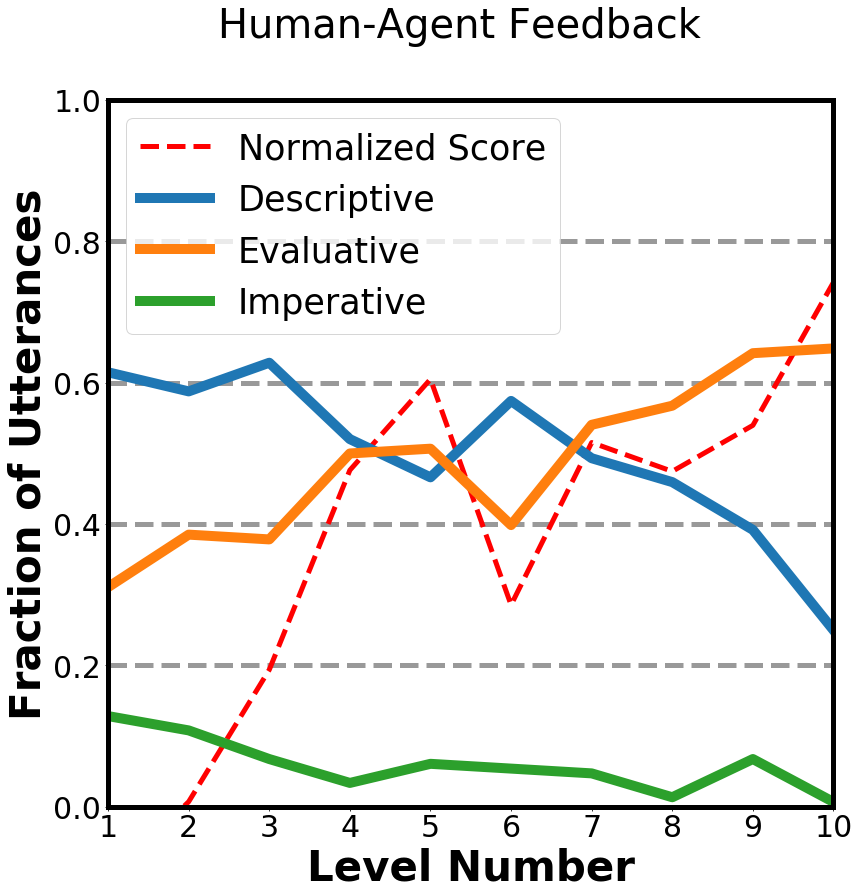

In [33]:
plt.figure(figsize=(13,13), linewidth=30)

for x in [.2, .4, .6, .8]:
    plt.axhline(x, linestyle='--', c='k', alpha=.4, linewidth=5)

agent_df["frac_max_score"] = agent_df.pct_max_score/100
agent_df.groupby("level_number").frac_max_score.mean().plot(label="Normalized Score", linewidth=5,linestyle='--', color='r')
    
agent_df.groupby("level_number").feature.mean().plot(label="Descriptive", linewidth=10)
agent_df.groupby("level_number").trajectory.mean().plot(label="Evaluative", linewidth=10)
agent_df.groupby("level_number").action.mean().plot(label="Imperative", linewidth=10)


plt.ylim(0,1)
plt.xlim(1, 10)
plt.legend(loc=2, prop={'size': 35})
plt.ylabel("Fraction of Utterances", fontsize=42, weight="bold")
plt.xlabel("Level Number", fontsize=42, weight="bold")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax = plt.gca()
ax.spines["top"].set_linewidth(5)
ax.spines["bottom"].set_linewidth(5)
ax.spines["left"].set_linewidth(5)
ax.spines["right"].set_linewidth(5)

plt.suptitle("Human-Agent Feedback", fontsize=40);
